# Using a neural network with inputs out of training bounds

The universal approximation theorem states that:
>  a feed-forward network with a single hidden layer containing a finite number of neurons can approximate continuous functions on compact subsets of Rn, under mild assumptions on the activation function[1]

An important requirement of the universal approximation theorem is that the approximation is limited to compact subsets of Rn, that is a closed subset of Euclidean space. If the trained neural network is used to predict the output of a function given inputs outside of the compact subset on which it was trained it may fail totally to produce a good approximation.

In this notebook we demonstrate this by training a single layer feed forward neural network to approximate the function y = x<sup>2</sup> We find that the neural network fails catastrophically to approximate the function outside of its training bounds.

[1]: Balázs Csanád Csáji (2001) Approximation with Artificial Neural Networks; Faculty of Sciences; Eötvös Loránd University, Hungary

In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def make_data_set(n=100,func=lambda x: x**2,start=-10,end=10):
    '''make data set of input X and y'''

    X = np.linspace(start,end,n)
    X = torch.tensor(X, dtype=torch.float).reshape([-1,1])
    y = func(X)
    y = torch.tensor(y, dtype=torch.float).reshape([-1,1])
    c = [ "blue"  if x == 0 else "red" for x in y]
    
    return X, y, c

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0)

class Net(nn.Module):
    def __init__(self, input_size, hidden_size,num_classes):
        super(Net, self).__init__()                    
        self.fc1 = nn.Linear(input_size, hidden_size,bias=True)  
        self.fc2 = nn.Linear(hidden_size, 1,bias=True)
        self.sig = nn.Sigmoid()
  
        self.apply(init_weights)

    
    def forward(self, x):                            
        out = self.fc1(x)
        out = self.sig(out)
        out = self.fc2(out)

        return out

def train_network(X,y):
    '''train single hidden layer network'''
    # Set network parameters
    input_size = 1       
    hidden_size = 50     
    num_classes = 1       
    num_epochs = 5000         
    batch_size = 100       
    learning_rate = 1  


    net = Net(input_size, hidden_size, num_classes)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()                            
        outputs = net(X)                             
        loss = criterion(outputs, y)                
        loss.backward()                                   
        optimizer.step()                                  
        
    return net

def plot_results(X,y,preds,lower_bound=-10,upper_bound=10):
    '''plot actual y vs output of neural network estimator'''
    
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(X_test,preds.detach().numpy(),label="neural network approximate function",marker=".",markersize=5)
    ax.plot(X_test,y_test,label="$y = x^2$")
    ax.axvline(lower_bound,color="black",linestyle="--",label="training bounds")
    ax.axvline(upper_bound,color="black",linestyle="--")
    ax.legend(loc="center",fontsize=12)
    ax.set_xlabel("x",fontsize=15)
    ax.set_ylabel("y",fontsize=15)
    title = "Demonstration of failure of feed forward neural network\nto approximate function out of training bounds"
    ax.set_title(title,fontsize=15)

In [2]:
# Make training and test sets

start_train=-10
end_train=10
start_test=-20
end_test=20

X_train, y_train, c_train = make_data_set(start=start_train,end=end_train)
X_test, y_test, c_test = make_data_set(start=start_test,end=end_test)

# Train nework
net = train_network(X_train,y_train)

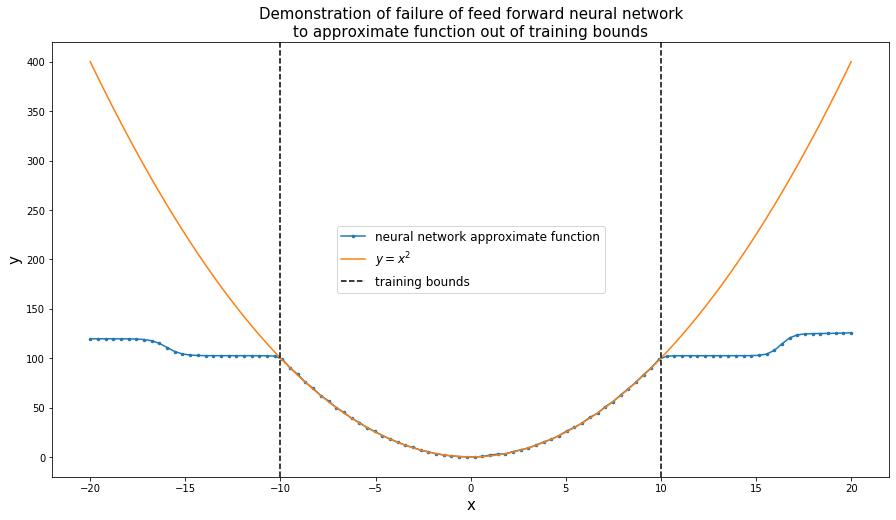

In [3]:
# make predictions on test set
preds_test = net(X_test) 

plot_results(X_test,y_test,preds_test)

### Analysis

The graphic above shows that the neural network was able to approximate the function $y = x^2$ perfectly within the training bounds, but immediately outside of the compact subset on which the model was trained, the model fails totally to approximate the function. This highlights the importance of being aware of the input domain the model was trained on and make sure that you only use the model to make predictions from valid input domains.

Note that some models can perform better at extrapolation, for example linear regression models or support vector machine with low order polynomial kernels. The development of neural network models which can extrapolate is an active area of research for example [Learning Equations for Extrapolations and Control](https://arxiv.org/pdf/1806.07259.pdf) by Sahoo et al.